## 0. Download dataset
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z/view?usp=sharing
!gdown --id 1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z
To: /content/image_retrieval_dataset.zip
100% 36.5M/36.5M [00:00<00:00, 46.8MB/s]


In [2]:
!unzip image_retrieval_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_mr/5415.jpg      
  inflating: images_mr/5416.jpg      
  inflating: images_mr/5417.jpg      
  inflating: images_mr/5418.jpg      
  inflating: images_mr/5419.jpg      
  inflating: images_mr/542.jpg       
  inflating: images_mr/5420.jpg      
  inflating: images_mr/5421.jpg      
  inflating: images_mr/5422.jpg      
  inflating: images_mr/5423.jpg      
  inflating: images_mr/5424.jpg      
  inflating: images_mr/5425.jpg      
  inflating: images_mr/5426.jpg      
  inflating: images_mr/5427.jpg      
  inflating: images_mr/5428.jpg      
  inflating: images_mr/5429.jpg      
  inflating: images_mr/543.jpg       
  inflating: images_mr/5430.jpg      
  inflating: images_mr/5431.jpg      
  inflating: images_mr/5432.jpg      
  inflating: images_mr/5433.jpg      
  inflating: images_mr/5434.jpg      
  inflating: images_mr/5435.jpg      
  inflating: images_mr/5436.jpg      
  inflating: images_mr/5437.jpg      

## 1. Import libraries

In [12]:
!pip install transformers==4.31.0 -q



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
pip list

Package               VersionNote: you may need to restart the kernel to use updated packages.

--------------------- -----------
asttokens             2.2.1
async-generator       1.10
attrs                 22.2.0
backcall              0.2.0
beautifulsoup4        4.11.2
certifi               2022.12.7
cffi                  1.15.1
charset-normalizer    3.1.0
click                 8.1.3
colorama              0.4.6
comm                  0.1.2
comtypes              1.1.14
contourpy             1.0.7
cycler                0.11.0
debugpy               1.6.6
decorator             5.1.1
docopt                0.6.2
exceptiongroup        1.1.1
executing             1.2.0
filelock              3.12.4
fonttools             4.39.0
fsspec                2023.9.2
gTTS                  2.3.1
h11                   0.14.0
huggingface-hub       0.17.2
idna                  3.4
ipykernel             6.22.0
ipython               8.11.0
jedi                  0.18.2
Jinja2                3.1.2
joblib        


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/172.3 MB 1.7 MB/s eta 0:01:39
     ---------------------------------------- 0.2/172.3 MB 1.5 MB/s eta 0:01:53
     ---------------------------------------- 0.3/172.3 MB 1.8 MB/s eta 0:01:38
     ---------------------------------------- 0.5/172.3 MB 2.1 MB/s eta 0:01:22
     ---------------------------------------- 0.5/172.3 MB 2.1 MB/s eta 0:01:23
     ---------------------------------------- 0.7/172.3 MB 2.3 MB/s eta 0:01:14
     ---------------------------------------- 0.9/172.3 MB 2.5 MB/s eta 0:01:09
     ---------------------------------------- 0.9/172.3 MB 2.4 MB/s eta 0:01:13
     ---------------------------------------- 1.0/172.3 MB 2.4 MB/s eta 0:01:11
     ---------------------------------------- 1.2/172.3 MB 2.6 MB/s eta 0:01:07
     ---------------------------------------- 1.4/172.


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
pip install torch


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

## 2. Load dataset

In [17]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)
src_images = []
for filename in image_filenames:
    filepath = os.path.join(
        dataset_dir,
        filename
    )

    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    src_images.append(image)

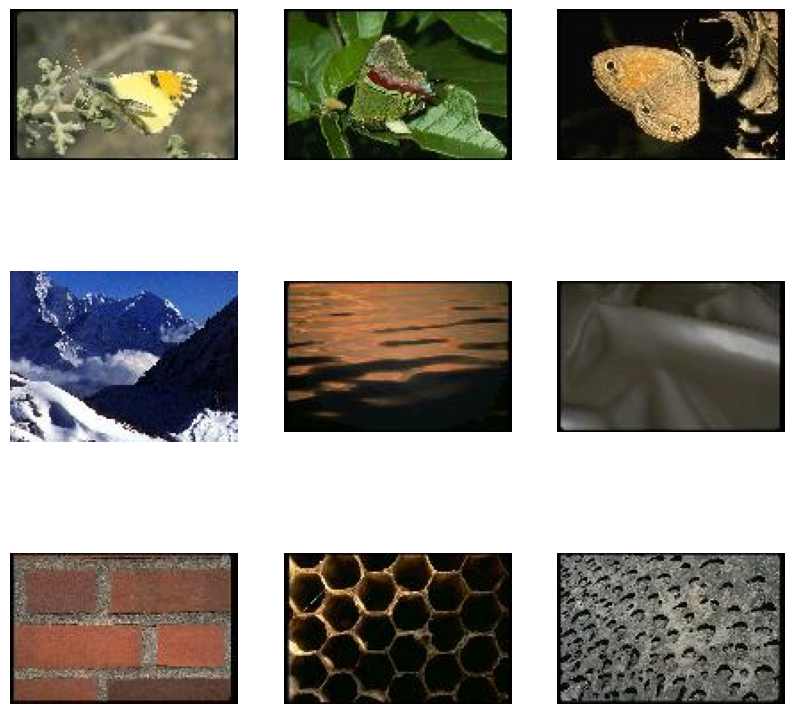

In [18]:
# Show some images
n_rows = 3
n_cols = 3
visualize_idx = 0

fig, ax = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(10, 10)
)

for idx in range(n_rows):
    for jdx in range(n_cols):
        ax[idx, jdx].imshow(src_images[visualize_idx])
        ax[idx, jdx].axis('off')
        visualize_idx += 1

## 3. Preprocess images

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224").to(device)

def preprocessing(images):
    inputs = processor(
        images,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        output = model(
            **inputs,
            output_hidden_states=True
        ).hidden_states[-1][:, 0, :].detach().cpu().numpy()

    return output

In [23]:
preprocessed_src_images = preprocessing(src_images)

ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

## 4. Define similarity metric

In [9]:
def mean_absolute_error(query_vector, src_vectors):
    abs_diff = np.abs(src_vectors - query_vector)
    mae = np.mean(abs_diff, axis=1)

    return mae

def mean_squared_error(query_vector, src_vectors):
    squared_diff = (src_vectors - query_vector) ** 2
    mse = np.mean(squared_diff, axis=1)

    return mse

def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector / query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1)
    normalized_src = src_vectors / src_norms[:, np.newaxis]

    cosine_similarity = np.dot(normalized_src, normalized_query)

    return cosine_similarity

def correlation_coefficient(query_vector, src_vectors):
    return np.corrcoef(query_vector, src_vectors)[:-1, -1]

In [10]:
test_query = preprocessed_src_images[0]

cosine_similarity(test_query, preprocessed_src_images)

array([ 1.00000000e+00,  7.65584335e-02,  2.51942351e-02,  1.10797048e-01,
        1.27934843e-01, -4.23374102e-02,  8.09109956e-02,  8.38773847e-02,
        1.56196766e-02,  2.06030756e-01,  6.80734068e-02,  5.93900084e-02,
        1.58539303e-02,  6.94900900e-02,  4.39509340e-02,  2.12921817e-02,
        1.48632564e-02,  9.44562480e-02,  2.19687726e-02,  1.07563101e-01,
        1.00690231e-01,  3.20507362e-02,  1.09708518e-01,  1.37133207e-02,
       -1.43406242e-02,  1.06686736e-02,  4.08639535e-02,  3.82789373e-02,
        7.83611313e-02,  1.12629384e-01,  8.74564573e-02,  3.85317393e-02,
        1.52199388e-01,  8.17376189e-03,  5.40857017e-02,  5.21606915e-02,
        4.19763550e-02,  2.50501364e-01,  8.93644467e-02,  4.17104401e-02,
        2.48549618e-02,  9.04631522e-03, -1.21660717e-02,  2.51500495e-02,
        2.66147554e-02,  3.18098217e-02, -9.65409540e-03,  1.86104774e-01,
        5.75402156e-02,  6.74733892e-03,  5.75812012e-02,  6.75685331e-03,
        6.03968054e-02,  

## 5. Ranking

In [11]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
    scores = cosine_similarity(
        preprocessed_query_image,
        preprocessed_src_images
    )
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]

    return ranked_list, scores

Query Image


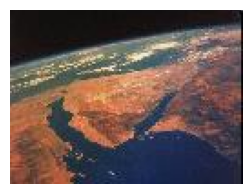

Top 10 results


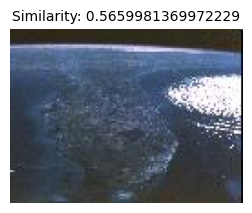

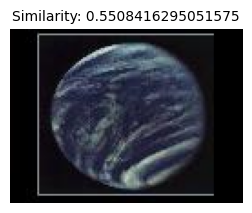

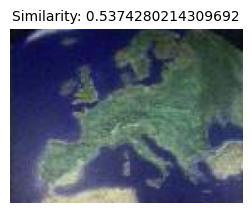

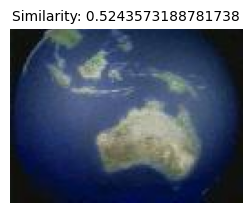

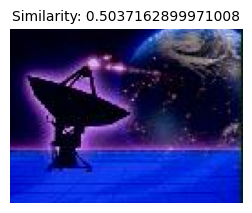

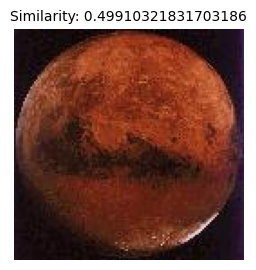

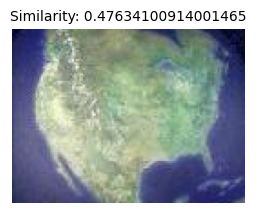

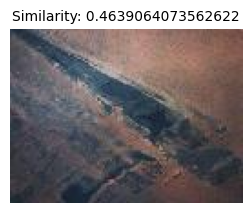

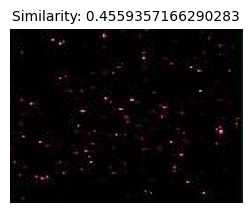

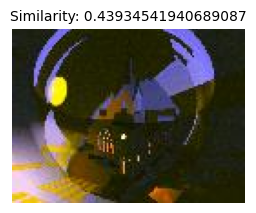

In [12]:
query_image_paths = [
    '/content/images_mr/615.jpg'
]
top_k = 10

for query_image_path in query_image_paths:
    query_image = cv2.imread(query_image_path, 1)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    preprocessed_query_image = preprocessing(query_image).squeeze(0)

    ranked_list, scores = ranking(
        preprocessed_query_image,
        preprocessed_src_images,
        top_k
    )

    print('Query Image')
    plt.figure(figsize=(3, 3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()
    print(f'Top {top_k} results')
    for idx in range(len(ranked_list)):
        src_image_idx = ranked_list[idx]
        similarity_score = scores[idx]
        plt.figure(figsize=(3, 3))
        plt.imshow(src_images[src_image_idx])
        plt.title(f'Similarity: {similarity_score}', fontsize=10)
        plt.axis('off')
        plt.show()